# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Цель проекта - обучить модель классифицировать комментарии на позитивные и негативные. Необходимо построить модель со значением метрики качества *F1* не меньше 0.75.

В нашем распоряжении набор данных с разметкой о токсичности правок.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.


**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Сделать выводы.




## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline

**Загрузка данных**

In [ ]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [ ]:
df.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


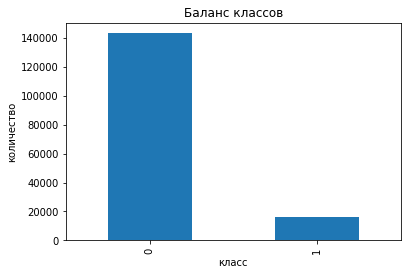

In [ ]:
df['toxic'].value_counts().plot.bar(xlabel='класс', ylabel='количество', title='Баланс классов');

**Разбивка на выборки**

In [ ]:
features = df['text']
target = df['toxic']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3,
                                                                            random_state=42, stratify=target)

In [ ]:
target_train.value_counts()

0    100174
1     11330
Name: toxic, dtype: int64

In [ ]:
target_test.value_counts()

0    42932
1     4856
Name: toxic, dtype: int64

In [ ]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((111504,), (47788,), (111504,), (47788,))

**Лемматизация**

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
tqdm.pandas()

In [ ]:
def lemmafunction(text):
    text = text.lower()
    text = "".join(re.sub(r'[^a-zA-Z]', ' ', text))
    text_tag = pos_tag(word_tokenize(text))
    wnl = WordNetLemmatizer()
    lemma = ([wnl.lemmatize(word,tag[0].lower()) if tag[0].lower() in ['a','n','v']
                                                 else wnl.lemmatize(word) for word,tag in text_tag])
    return " ".join(lemma)

In [ ]:
lemma_text_train = features_train.progress_apply(lemmafunction)

  0%|          | 0/111504 [00:00<?, ?it/s]

In [ ]:
lemma_text_test = features_test.progress_apply(lemmafunction)

  0%|          | 0/47788 [00:00<?, ?it/s]

**TF-IDF**

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.5, ngram_range=(1,2))

In [ ]:
tf_idf_train = count_tf_idf.fit_transform(lemma_text_train)

In [ ]:
tf_idf_test = count_tf_idf.transform(lemma_text_test)

In [ ]:
tf_idf_train.shape, tf_idf_test.shape

((111504, 366282), (47788, 366282))

Данные содержат 159292 строк и 3 столбца. Присутствует дисбаланс классов. Данные были разбиты на обучающую и тестовую выборки. Тексты были лимматизированы. Было вычислено TF-IDF.  

## Обучение

**LogisticRegression**

In [ ]:
pipe_lr = Pipeline([('tfidf', count_tf_idf),
                    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', C=10))])

In [ ]:
pipe_lr.fit(lemma_text_train, target_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2),
                                 stop_words='english')),
                ('classifier',
                 LogisticRegression(C=10, class_weight='balanced',
                                    random_state=42, solver='liblinear'))])

In [ ]:
f1 = cross_val_score(pipe_lr, lemma_text_train, target_train, cv=3, scoring='f1').mean()
print('F1:', f1)

F1: 0.7673883163648628


**RandomForestClassifier**

In [ ]:
pipe_rf = Pipeline([('tfidf', count_tf_idf),
                  ('classifier', RandomForestClassifier(random_state=42, n_estimators=20, class_weight ='balanced'))])

In [ ]:
f1 = cross_val_score(pipe_rf, lemma_text_train, target_train, cv=3, scoring='f1').mean()
print('F1:', f1)

F1: 0.5898116021837043


**CatBoostClassifier**

In [ ]:
pipe_cb = Pipeline([('tfidf', count_tf_idf),
                    ('classifier', CatBoostClassifier(loss_function = 'Logloss', iterations=10, random_state=42))])

In [ ]:
f1_cb = cross_val_score(pipe_cb, lemma_text_train, target_train, scoring='f1', cv=3).mean()
print('F1:', f1_cb)

Learning rate set to 0.5
0:	learn: 0.3496976	total: 4.03s	remaining: 36.3s
1:	learn: 0.2604906	total: 7.3s	remaining: 29.2s
2:	learn: 0.2350147	total: 10.4s	remaining: 24.2s
3:	learn: 0.2196589	total: 13.9s	remaining: 20.9s
4:	learn: 0.2110228	total: 17.3s	remaining: 17.3s
5:	learn: 0.2047636	total: 20.6s	remaining: 13.7s
6:	learn: 0.1998427	total: 24.1s	remaining: 10.3s
7:	learn: 0.1951979	total: 27.6s	remaining: 6.89s
8:	learn: 0.1908876	total: 31s	remaining: 3.44s
9:	learn: 0.1873530	total: 34.3s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3486971	total: 4.76s	remaining: 42.8s
1:	learn: 0.2604931	total: 8.66s	remaining: 34.6s
2:	learn: 0.2339930	total: 12.5s	remaining: 29.2s
3:	learn: 0.2191295	total: 16.4s	remaining: 24.6s
4:	learn: 0.2114531	total: 20.6s	remaining: 20.6s
5:	learn: 0.2037256	total: 24.1s	remaining: 16s
6:	learn: 0.1976821	total: 27.7s	remaining: 11.9s
7:	learn: 0.1939609	total: 31.2s	remaining: 7.79s
8:	learn: 0.1900135	total: 35s	remaining: 3.88s
9:	learn:

**Тестирование лучшей модели**

In [ ]:
predict1 = pipe_lr.predict(lemma_text_test)
f1_score(target_test, predict1)

0.7754442649434572

## Выводы

Для определения тональности были применены величины TF-IDF как признаки. Кросс-валидацией были протестированы три модели LogisticRegression, RandomForestClassifier, CatBoostClassifier. Модели RandomForestClassifier и CatBoostClassifier показали плохое качество метрики F1 (0.59 и 0.61 соответственно). Указанные модели для решения данной задачи не подходят.  Лучшие результаты метрики качества F1 (не меньше 0.75) показала модель LogisticRegression, было применено взвешивание классов. Данная модель была проверена на тестовой выборке и показала значение F1: 0.7754442649434572, эту модель можно использовать для классификации комментариев на позитивные и негативные.